# Pandas for Time Series Analytics

Although we use Pandas for all types of tabular data, Pandas in fact started specifically as a time series analysis library and its roots show in the data methodology it provides. The core Pandas object is the `Series` (as in time series) which is described by an `Index` as well as its values. Multiple series combined with the same index is a `DataFrame`. And although there are now a host of methods for tabular analytics that are similar to those you might find in a database, many of the original methods deal with time and temporal manipulation.

In [37]:
%matplotlib notebook

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Some default styles for figures
mpl.rcParams['figure.figsize'] = (9, 6)
mpl.rcParams['axes.grid'] = False

## Data Types

In pandas, time is represented as a `Timestamp` object which uses the `np.datetime64` dtype under the hood. Time representations vary, but the following types can usually be automatically translated into `Timestamps`:

- Epoch time (int) seconds or nanoseconds since 23:59:59.9999 on December 31, 1969
- Correctly formatted timestamp (str), usually using [RFC3339](https://medium.com/easyread/understanding-about-rfc-3339-for-datetime-formatting-in-software-engineering-940aa5d5f68a): `"2020-04-07 18:31:42.221"`
- Python `datetime` object
- `np.datetime64` object 

A quick way to parse timestamps is to use the `pd.to_datetime` function:

In [4]:
ts = pd.to_datetime('2020-04-07 18:31:42.222')
type(ts)

pandas._libs.tslibs.timestamps.Timestamp

Note that the `pd.to_datetime` function attempts to automatically parse the string based on the format, but you can pass a [Python time format string](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) to strictly specify how to parse the timestamp.

In [6]:
idx = pd.to_datetime(['04/06/2020', '04/08/2020', '04/10/2020'], format='%m/%d/%Y')
print(idx.dtype)
type(idx)

datetime64[ns]


pandas.core.indexes.datetimes.DatetimeIndex

Note that when you parse a list of timestamps a `pd.DatetimeIndex` is returned. This index provides most of the core functionality for handling time series data in Python. It is also important to note that under the hood, the `dtype` of the index is a [`np.datetime64`](https://docs.scipy.org/doc/numpy-1.15.0/reference/arrays.datetime.html), a 64-bit int64 in nanosecond units (`[ns]`). This allows compact storage of timestamps and efficient vectorized operations. 

A univariate time series dataset can be represented as `pd.Series` object whose index is a `pd.DatetimeIndex` and whose values are the values of the dataset. We can create a series for 3 years of monthly shampoo data sales as follows:

<IPython.core.display.Javascript object>


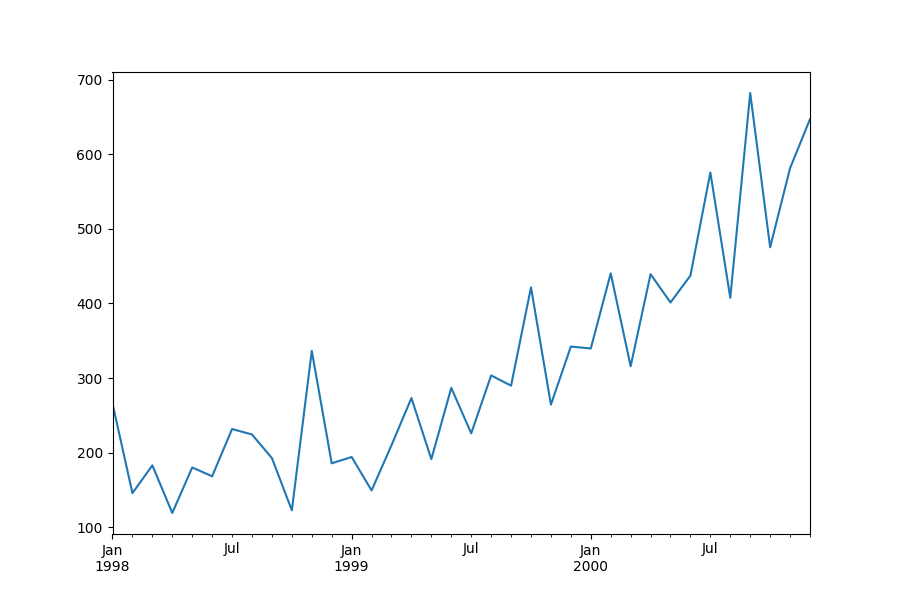

<AxesSubplot:>

In [38]:
values = [266.0, 145.9, 183.1, 119.3, 180.3, 168.5, 231.8, 224.5, 192.8, 122.9, 336.5, 185.9, 194.3, 149.5, 210.1, 273.3, 191.4, 287.0, 226.0, 303.6, 289.9, 421.6, 264.5, 342.3, 339.7, 440.4, 315.9, 439.3, 401.3, 437.4, 575.5, 407.6, 682.0, 475.3, 581.3, 646.9]
months = pd.date_range(start='1998-01', periods=len(values), freq='M')
series = pd.Series(np.asarray(values), index=months, name="Shampoo Sales")

series.plot()

Note that the `pd.date_range` function is another useful method for generating `DatetimeIndex` objects where you can specify the start and end dates (or number of periods) and generate all time values within a specific frequency. 

The `frequency` of a date range or an index describes the _granularity_ of the sample interval. Pandas uses [short codes](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases) to specify different frequencies. For example, `"D"` is the calendar day frequency, `"B"` the business day frequency, `"Q"` the quarter-end frequency, `"YS"` the year start frequency, etc. 

Also note that plotting the `pd.Series` results in a sensible matplotlib figure, with a correct datetime axis at the bottom! It turns out that this is pretty tricky, so it's nice that Pandas does the work for us! 

In [16]:
df = pd.read_csv(
    'datasets/energy/nyc_energy.csv.gz',
    index_col='timeStamp',
    parse_dates=True,
)

df.head()

,demand,precip,temp
timeStamp,,,
2012-01-01 00:00:00,4937.5,0.0,46.13
2012-01-01 01:00:00,4752.1,0.0,45.89
2012-01-01 02:00:00,4542.6,0.0,45.04
2012-01-01 03:00:00,4357.7,0.0,45.03
2012-01-01 04:00:00,4275.5,0.0,42.61


Note that a `pd.DataFrame` is just several `pd.Series` objects with the same index! When loading time series data, make sure to specify `parse_dates=True` which will use `pd.to_datetime` on the `index_col` specified in the loader. 

<IPython.core.display.Javascript object>


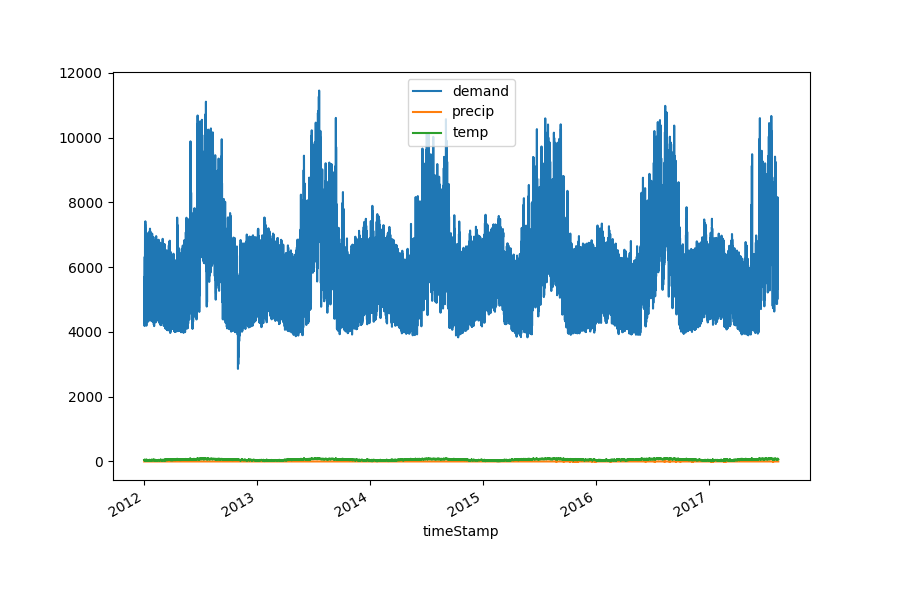

<AxesSubplot:xlabel='timeStamp'>

In [17]:
df.plot()

## Time Series Queries

Often we will want to interact with time series data to quickly view features that may be hidden at a global level. Pandas offers several tools for indexing and resampling time series data at different aggregations.

### Time Indexes

The index can be accessed using time-specific queries using slicing methods that you would expect but with `Timestamp` objects.

In [29]:
demand = df['demand']

In [30]:
demand['2014-03-01 02:00:00':'2014-03-01 22:00:00']

timeStamp
2014-03-01 02:00:00    5027.0
2014-03-01 03:00:00    4944.6
2014-03-01 04:00:00    4921.9
2014-03-01 05:00:00    4954.4
2014-03-01 06:00:00    5107.3
2014-03-01 07:00:00    5331.4
2014-03-01 08:00:00    5630.4
2014-03-01 09:00:00    5843.0
2014-03-01 10:00:00    5999.3
2014-03-01 11:00:00    6052.6
2014-03-01 12:00:00    6012.2
2014-03-01 13:00:00    5952.9
2014-03-01 14:00:00    5887.0
2014-03-01 15:00:00    5896.4
2014-03-01 16:00:00    5987.6
2014-03-01 17:00:00    6074.0
2014-03-01 18:00:00    6235.0
2014-03-01 19:00:00    6180.4
2014-03-01 20:00:00    6050.9
2014-03-01 21:00:00    5888.7
2014-03-01 22:00:00    5661.4
Name: demand, dtype: float64

Additionally you can access the index for all values for a specific granularity of time, e.g. a year or a month

In [31]:
demand['2016'].head()

timeStamp
2016-01-01 00:00:00    4919.758
2016-01-01 01:00:00    4737.992
2016-01-01 02:00:00    4533.225
2016-01-01 03:00:00    4388.150
2016-01-01 04:00:00    4294.242
Name: demand, dtype: float64

In [32]:
demand['2016-04'].head()

timeStamp
2016-04-01 00:00:00    4588.558
2016-04-01 01:00:00    4346.117
2016-04-01 02:00:00    4205.250
2016-04-01 03:00:00    4120.583
2016-04-01 04:00:00    4142.692
Name: demand, dtype: float64

Use the `.loc` function to perform these operations on a `pd.DataFrame`:

In [36]:
df.loc['2014-03-01 02:00:00':'2014-03-01 22:00:00'].head()

,demand,precip,temp
timeStamp,,,
2014-03-01 02:00:00,5027.0,0.0,20.69
2014-03-01 03:00:00,4944.6,0.0,20.98
2014-03-01 04:00:00,4921.9,0.0,20.79
2014-03-01 05:00:00,4954.4,0.0,20.79
2014-03-01 06:00:00,5107.3,0.0,20.31


### Specify frequency of existing data

In the above dataset, we expect hourly data, but what if some values are missing? We may want to interpolate this data or ensure that our expected frequency/sample rate is correct. We can use the `asfreq` function to specify the frequency, along with a `method` to pad or backfill missing values as a result. For example to go down to a half hour granularity and fill `NaN` values (default):

[Learn more about frequency strings](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

In [33]:
demand.asfreq(freq="30T").head()

timeStamp
2012-01-01 00:00:00    4937.5
2012-01-01 00:30:00       NaN
2012-01-01 01:00:00    4752.1
2012-01-01 01:30:00       NaN
2012-01-01 02:00:00    4542.6
Freq: 30T, Name: demand, dtype: float64

In [35]:
# Ensure that we're at an hourly sample rate and fill in NaN where necessary
demand.asfreq(freq="1H").head()

timeStamp
2012-01-01 00:00:00    4937.5
2012-01-01 01:00:00    4752.1
2012-01-01 02:00:00    4542.6
2012-01-01 03:00:00    4357.7
2012-01-01 04:00:00    4275.5
Freq: H, Name: demand, dtype: float64

### Resampling

Resampling allows us to aggregate our data to a lower frequency (downsampling) or, less commonly, to a higher frequency (upsampling) that involves an interpolation method. The `resample` method returns a `Resampler` object similar to the `GroupBy` object, which allows us to specify the aggregation method for each bin.

<IPython.core.display.Javascript object>


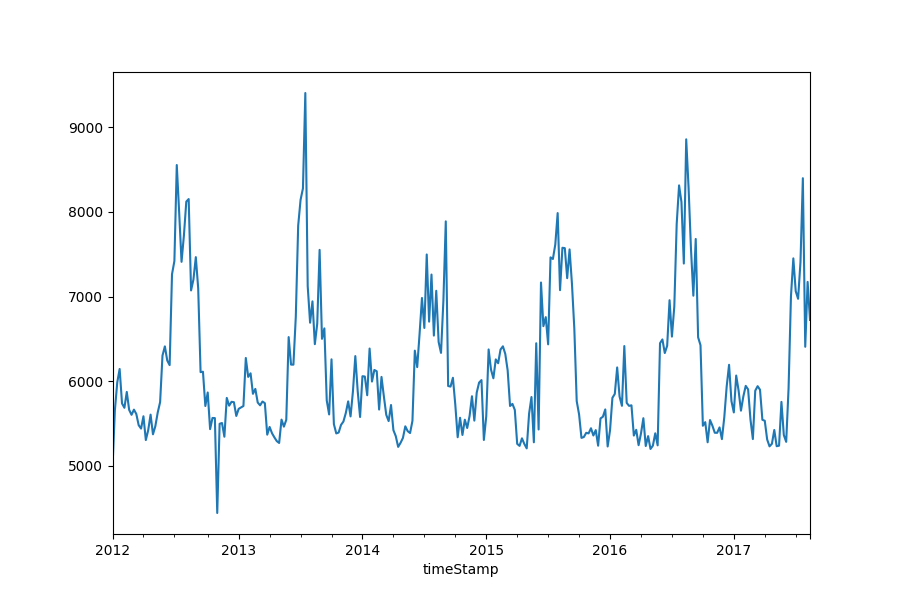

<AxesSubplot:xlabel='timeStamp'>

In [39]:
# Resample by weekly median
demand.resample('W').median().plot()

<IPython.core.display.Javascript object>


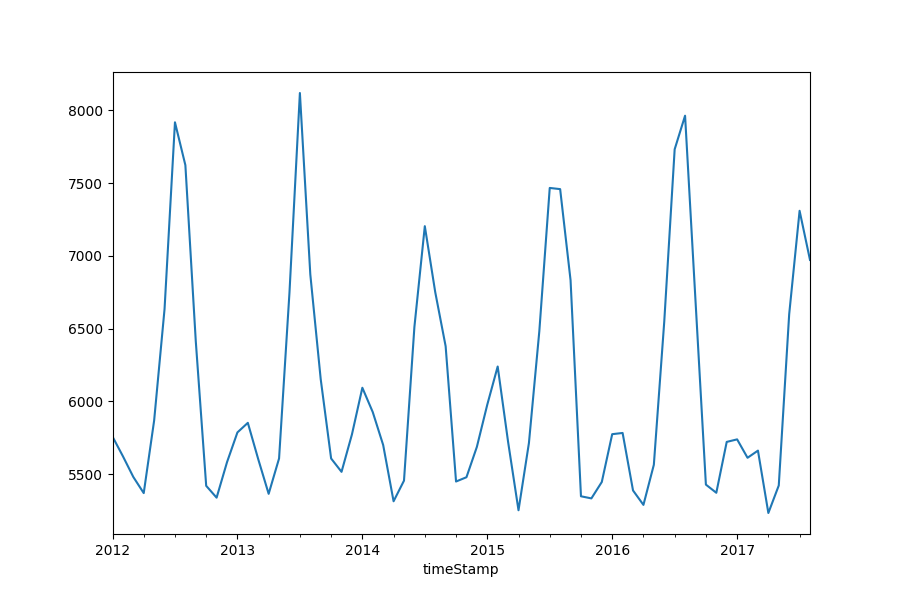

<AxesSubplot:xlabel='timeStamp'>

In [41]:
# Resample by monthly mean
demand.resample('MS').mean().plot()

## Seasonality

Using the resampling methods we can see that there are seasonal trends in energy demand - probably due to additional heating or cooling load as the weather changes. We can investigate these trends using box plots by first grouping by month:

In [57]:
df["Month"] = df.index.month

<IPython.core.display.Javascript object>


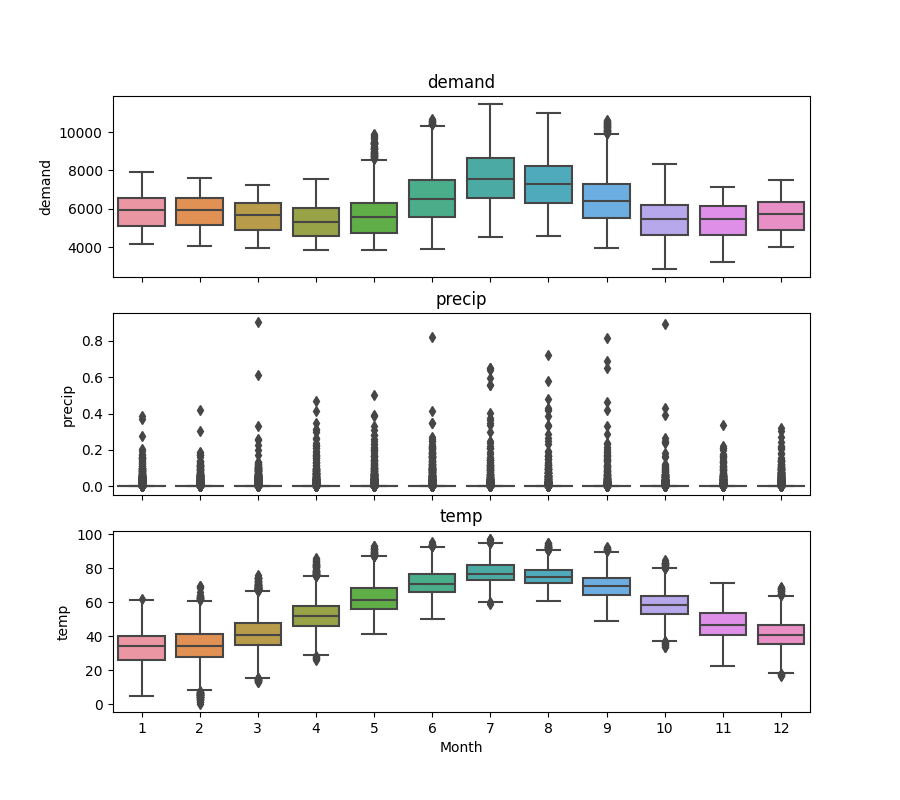

In [62]:
_, axes = plt.subplots(3, 1, figsize=(9,8), sharex=True)
for col, ax in zip(df.columns, axes):
    sns.boxplot(data=df, x="Month", y=col, ax=ax)
    ax.set_title(col)
    
    # Remove xlabel from all but last figure
    if ax != axes[-1]:
        ax.set_xlabel("")

In [66]:
df["Day"] = df.index.weekday

<IPython.core.display.Javascript object>


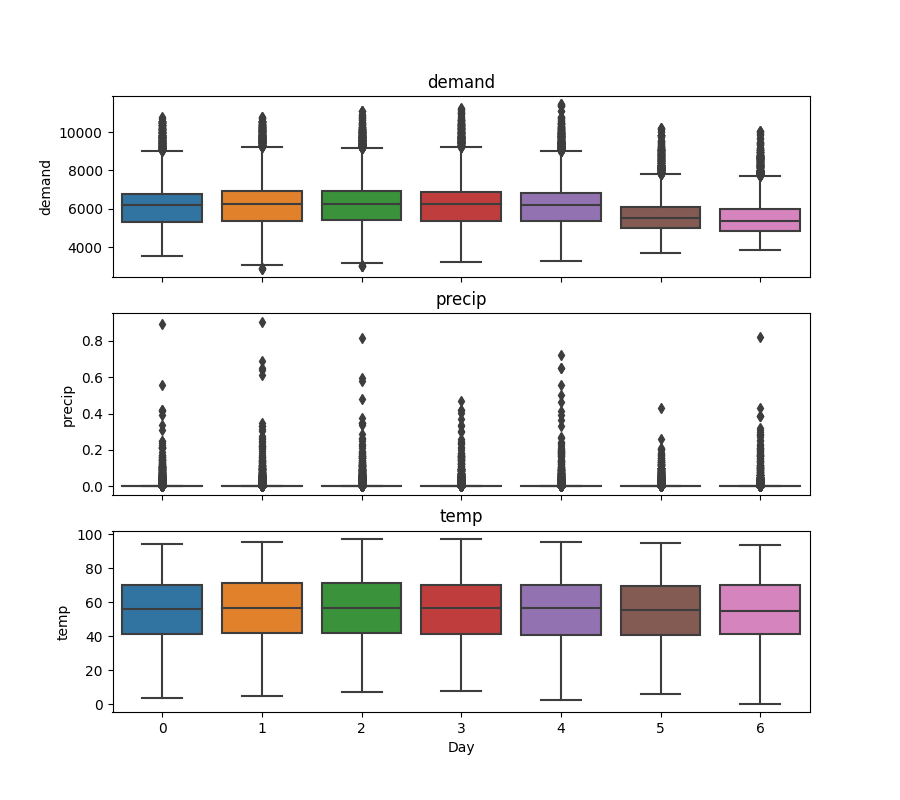

In [69]:
_, axes = plt.subplots(3, 1, figsize=(9,8), sharex=True)
for col, ax in zip(df.columns, axes):
    sns.boxplot(data=df, x="Day", y=col, ax=ax)
    ax.set_title(col)
    
    # Remove xlabel from all but last figure
    if ax != axes[-1]:
        ax.set_xlabel("")

These figures show us that electric energy consumption is higher in the summer (cooling load) and less on the weekend (e.g. when commuters are not coming into the city). 

## Rolling Windows

Resampling is an example of `windowing` -- aggregating data across a fixed length window. Another important transformation for time series data is a rolling window. The difference between a rolling window and downsampling is that the windows overlap each other (or roll) as they move over the data.

In [72]:
# Compute the 8 hour roling window labelling each window at its midpoint with center=True
demand.rolling(8, center=True).mean().head(20)

timeStamp
2012-01-01 00:00:00          NaN
2012-01-01 01:00:00          NaN
2012-01-01 02:00:00          NaN
2012-01-01 03:00:00          NaN
2012-01-01 04:00:00    4476.8750
2012-01-01 05:00:00    4419.8000
2012-01-01 06:00:00    4408.8125
2012-01-01 07:00:00    4446.9250
2012-01-01 08:00:00    4524.9500
2012-01-01 09:00:00    4625.6375
2012-01-01 10:00:00    4733.4500
2012-01-01 11:00:00    4835.6625
2012-01-01 12:00:00    4937.5500
2012-01-01 13:00:00    5046.3250
2012-01-01 14:00:00    5171.3000
2012-01-01 15:00:00    5277.8500
2012-01-01 16:00:00    5358.1875
2012-01-01 17:00:00    5417.4875
2012-01-01 18:00:00    5458.2125
2012-01-01 19:00:00    5474.1000
Name: demand, dtype: float64

Let's compare the values, rolling mean, and resampling in a single figure:

<IPython.core.display.Javascript object>


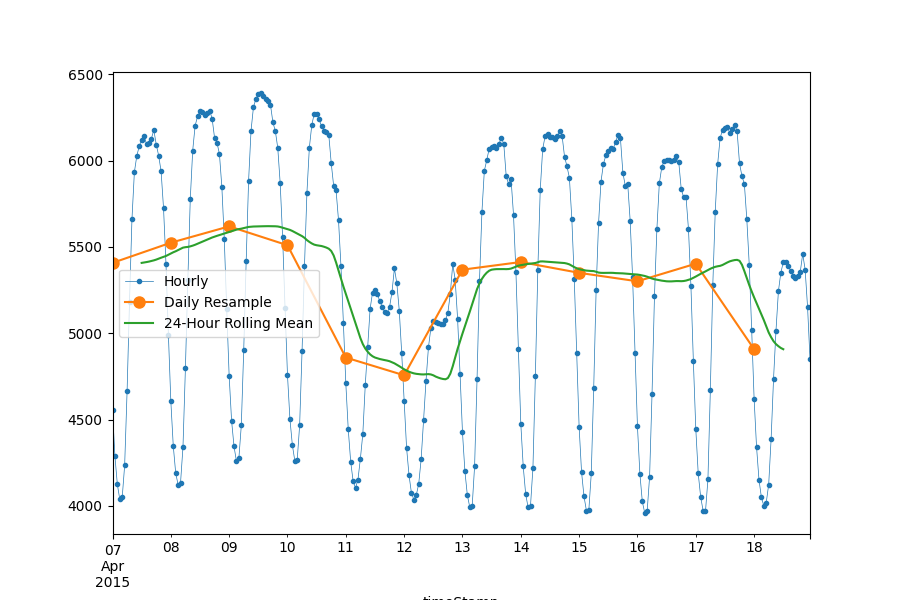

In [80]:
start = "2015-04-07"
end = "2015-04-18"

# Plot the original data
_, ax = plt.subplots()
demand[start:end].plot(ax=ax, marker='.', linestyle='-', linewidth='0.5', label='Hourly')

# Plot a daily resampling
demand[start:end].resample('D').mean().plot(ax=ax, marker='o', markersize=8, label='Daily Resample')

# Plot 24-hour rolling mean
demand[start:end].rolling(24, center=True).mean().plot(ax=ax, label='24-Hour Rolling Mean')

ax.legend()